### Install Dependencies

In [2]:
%pip install pandas matplotlib prophet scikit-learn seaborn datasets torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -U transformers

Note: you may need to restart the kernel to use updated packages.


### Dataset Analyze and Cleaning

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Bank_Transaction_Dataset.csv", parse_dates=["Transaction_Date"])

# Preview
print(df.shape)
print(df.dtypes)
df.tail()

(200000, 24)
Customer_ID                        object
Customer_Name                      object
Gender                             object
Age                                 int64
State                              object
City                               object
Bank_Branch                        object
Account_Type                       object
Transaction_ID                     object
Transaction_Date           datetime64[ns]
Transaction_Time                   object
Transaction_Amount                float64
Merchant_ID                        object
Transaction_Type                   object
Merchant_Category                  object
Account_Balance                   float64
Transaction_Device                 object
Transaction_Location               object
Device_Type                        object
Is_Fraud                            int64
Transaction_Currency               object
Customer_Contact                   object
Transaction_Description            object
Customer_Email       

/var/folders/5y/wz5xr6w53tb0sqrrgqvz2r1m0000gn/T/ipykernel_58699/2978175523.py:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("Bank_Transaction_Dataset.csv", parse_dates=["Transaction_Date"])


,Customer_ID,Customer_Name,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,...,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Customer_Contact,Transaction_Description,Customer_Email
199995,b8bdae19-296f-48b7-9104-e055d33a09ac,Vedhika Magar,Female,55,Dadra and Nagar Haveli and Daman and Diu,Diu,Diu Branch,Business,8d856bc7-4666-4509-a067-48d67500694a,2025-01-08,...,Restaurant,37475.11,Desktop/Laptop,"Diu, Dadra and Nagar Haveli and Daman and Diu",ATM,0,INR,+9192629XXXXXX,ATM withdrawal,vedhikaXXXXX@XXXXXXX.com
199996,635bc099-8a93-48ee-829a-bf2283fe8fda,Aashi Pai,Male,51,Manipur,Kangpokpi,Kangpokpi Branch,Business,f2890dbd-4e01-445d-97f5-ac56886e9037,2025-01-01,...,Groceries,53037.20,ATM,"Kangpokpi, Manipur",ATM,0,INR,+9198116XXXXXX,Subscription box,aashiXXX@XXXXXX.com
199997,c1b31cc2-0905-47e8-8cc5-6461d1f3ba33,Dayita Shan,Female,41,Chandigarh,Chandigarh,Chandigarh Branch,Savings,f714b758-7539-474d-b676-5fa7e2480141,2025-01-28,...,Health,96225.36,ATM,"Chandigarh, Chandigarh",Desktop,0,INR,+9192601XXXXXX,Charity donation,dayitaXXXX@XXXXXXX.com
199998,32bb8e66-f3fa-43bf-8242-dab9a6116310,Unnati Vyas,Female,28,Telangana,Nizamabad,Nizamabad Branch,Checking,f6903b6a-b582-47ea-95d5-aff16bdec950,2025-01-08,...,Electronics,89599.90,Voice Assistant,"Nizamabad, Telangana",Desktop,0,INR,+9197537XXXXXX,Tourist attraction payment,unnatiXXX@XXXXX.com
199999,f3dd92ef-b17a-45d2-b6cb-fdbee20843fe,Gopal Rout,Male,34,Nagaland,Kohima,Kohima Branch,Business,b44b6e8a-1036-4ec1-b492-5e7ffc7baf6d,2025-01-08,...,Electronics,15066.24,Virtual Card,"Kohima, Nagaland",Mobile,0,INR,+9193961XXXXXX,Installment payment,gopalXXXXX@XXXXXXX.com


In [5]:
print(df['Transaction_Amount'].describe())

#check if transaction amount has NaN values
print('Number of NaN values in Transaction Amount:', df['Transaction_Amount'].isna().sum())

count    200000.000000
mean      49538.015554
std       28551.874004
min          10.290000
25%       24851.345000
50%       49502.440000
75%       74314.625000
max       98999.980000
Name: Transaction_Amount, dtype: float64
Number of NaN values in Transaction Amount: 0


In [6]:
# Preview unique transaction types
print(df['Transaction_Type'].unique())

df['Transaction_Type'] = df['Transaction_Type'].str.strip().str.lower()

# Map types to sign
def get_signed_amount(row):
    return row['Transaction_Amount'] if row['Transaction_Type'] == 'credit' else -row['Transaction_Amount']

# Apply the fixed version
df['Signed_Amount'] = df.apply(get_signed_amount, axis=1)

# Check again
df[['Transaction_Type', 'Transaction_Amount', 'Signed_Amount']].head()

['Transfer' 'Bill Payment' 'Debit' 'Withdrawal' 'Credit']


,Transaction_Type,Transaction_Amount,Signed_Amount
0,transfer,32415.45,-32415.45
1,bill payment,43622.60,-43622.60
2,bill payment,63062.56,-63062.56
3,debit,14000.72,-14000.72
4,transfer,18335.16,-18335.16


<Axes: title={'center': 'Daily Net Cash Flow'}, xlabel='Transaction_Date'>

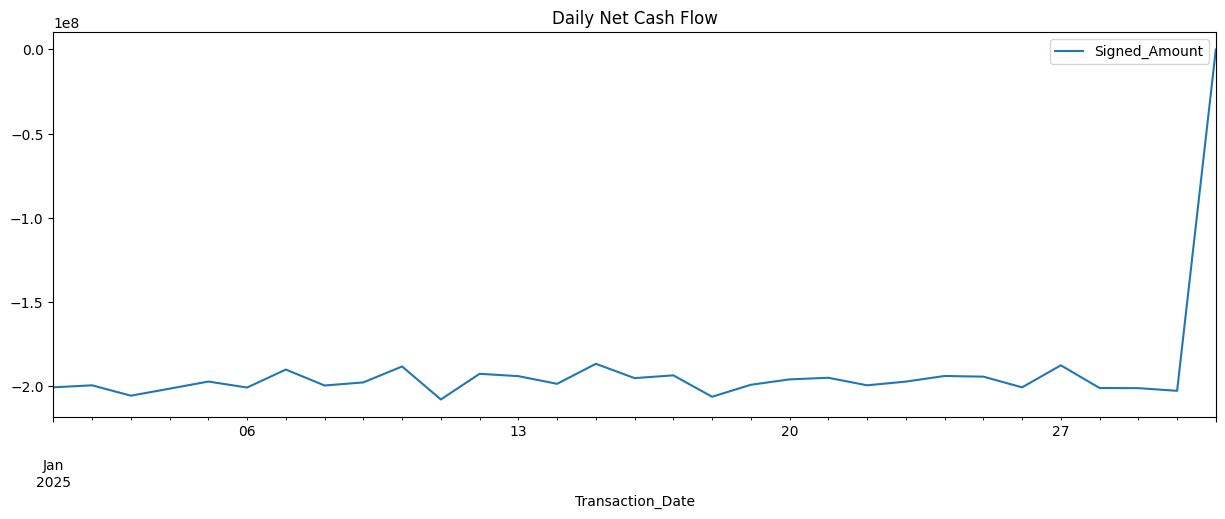

In [7]:
# Group by date
daily_cashflow = df.groupby('Transaction_Date')['Signed_Amount'].sum().reset_index()

# Set date as index
daily_cashflow.set_index('Transaction_Date', inplace=True)

# Plot it
daily_cashflow.plot(figsize=(15, 5), title="Daily Net Cash Flow")

### Cash Flow Forecasting

In [8]:
from prophet import Prophet

df_prophet = daily_cashflow.reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet needs these exact names

df_prophet.head()

/Users/usmanghani/Desktop/Personal Projects/Cash Flow Forecasting/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


,ds,y
0,2025-01-01,-2.006513e+08
1,2025-01-02,-1.994558e+08
2,2025-01-03,-2.056088e+08
3,2025-01-04,-2.014620e+08
4,2025-01-05,-1.972158e+08


In [ ]:
model = Prophet()
model.fit(df_prophet)


# Make future dataframe
future = model.make_future_dataframe(periods=30)  # next 30 days
forecast = model.predict(future)

# create forecast.csv and save it
forecast.to_csv("forecast.csv", index=False)

# Plot forecast
fig = model.plot(forecast)

08:35:36 - cmdstanpy - INFO - Chain [1] start processing


08:35:36 - cmdstanpy - INFO - Chain [1] done processing


AttributeError: 'Prophet' object has no attribute 'save_pretrained'

In [82]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial='20 days', period='5 days', horizon='7 days')
df_p = performance_metrics(df_cv)
print(df_p[['horizon', 'mae', 'rmse']])

  0%|          | 0/1 [00:00<?, ?it/s]06:36:28 - cmdstanpy - INFO - Chain [1] start processing
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
06:36:28 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00, 13.49it/s]

  horizon           mae          rmse
0  1 days  1.104016e+07  1.104016e+07
1  2 days  3.818120e+06  3.818120e+06
2  3 days  1.004679e+07  1.004679e+07
3  4 days  5.616550e+06  5.616550e+06
4  5 days  4.348747e+06  4.348747e+06
5  6 days  4.838319e+06  4.838319e+06
6  7 days  1.960812e+08  1.960812e+08


### Transaction Categorization

In [83]:
df['Merchant_Category'].value_counts()

Merchant_Category
Restaurant       33525
Entertainment    33421
Electronics      33409
Clothing         33340
Groceries        33187
Health           33118
Name: count, dtype: int64

In [84]:
import pandas as pd
from datasets import Dataset

# Clean and filter
df = df[df['Merchant_Category'].notnull()].copy()
df['text'] = df['Transaction_Description'].fillna("").str.lower().str.strip()
df = df[['text', 'Merchant_Category']]

# Encode labels
labels = df['Merchant_Category'].unique().tolist()
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}
df['label'] = df['Merchant_Category'].map(label2id)

# Convert to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df[['text', 'label']])
hf_dataset = hf_dataset.train_test_split(test_size=0.2)

In [85]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

tokenized_dataset = hf_dataset.map(tokenize, batched=True)

Map: 100%|██████████| 40000/40000 [00:00<00:00, 44262.82 examples/s]


In [106]:
import torch
from transformers import DistilBertForSequenceClassification
from torch.optim import AdamW  # Import AdamW from torch.optim instead
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Load model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set dataset format to PyTorch tensors
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Import data collator for padding
from transformers import DataCollatorWithPadding

# Create data collator (assumes you have 'tokenizer' available)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create data loaders with padding
train_loader = DataLoader(tokenized_dataset["train"], batch_size=16, shuffle=True, collate_fn=data_collator)
eval_loader = DataLoader(tokenized_dataset["test"], batch_size=16, shuffle=False, collate_fn=data_collator)

# Setup optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training function
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        # Move batch to device - handle both tensor and list formats
        if isinstance(batch['input_ids'], list):
            input_ids = torch.tensor(batch['input_ids']).to(device)
            attention_mask = torch.tensor(batch['attention_mask']).to(device)
            labels = torch.tensor(batch['labels']).to(device)
        else:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(model, eval_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in eval_loader:
            # Handle both tensor and list formats
            if isinstance(batch['input_ids'], list):
                input_ids = torch.tensor(batch['input_ids']).to(device)
                attention_mask = torch.tensor(batch['attention_mask']).to(device)
                labels = torch.tensor(batch['labels']).to(device)
            else:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    
    return accuracy, f1

# Training loop
num_epochs = 3
best_accuracy = 0
best_model_state = None

print("Starting training...")
for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, device)
    
    # Evaluate
    accuracy, f1 = evaluate(model, eval_loader, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Eval Accuracy: {accuracy:.4f}")
    print(f"Eval F1: {f1:.4f}")
    print("-" * 30)
    
    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict().copy()

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Best model loaded with accuracy: {best_accuracy:.4f}")

print("Training completed!")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...
Epoch 1/3
Train Loss: 1.7931
Eval Accuracy: 0.1653
Eval F1: 0.0469
------------------------------


KeyboardInterrupt: 